In [1]:
import os, sys

import torch

%load_ext autoreload
%autoreload 2

current = os.path.dirname(os.path.realpath("*.ipynb"))
parent = os.path.dirname(current)
sys.path.append(parent)
%cd ..

/Users/singh/Documents/acad_repos/differential-privacy


/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# !python mnist.py --num-epochs 10 

In [3]:
from mnist import *

/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <AD0702F8-F0F4-3872-8C19-A834018634B4> /opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
device = torch.device(
    'cuda' if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    'cpu'
)

# data loaders
train_data = datasets.MNIST(
    root='data', download=True, train=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(
    root='data', download=True, train=False, transform=transforms.ToTensor())

In [30]:
# apply PCA to the dataset (as done in the paper)
X_train = train_data.train_data.reshape(len(train_data), -1)
X_test = test_data.test_data.reshape(len(test_data), -1)

A = torch.cat([X_train, X_test]).float()

In [31]:
_, _, V = torch.pca_lowrank(A, q=60)
V.shape

torch.Size([784, 60])

In [32]:
res = torch.matmul(A, V)
res.shape

torch.Size([70000, 60])

In [34]:
X_train_pca_tensor = res[:60000]
X_test_pca_tensor = res[60000:]
y_train = train_data.targets
y_test = test_data.targets

# create torch datasets
train_dataset = TensorDataset(X_train_pca_tensor, y_train)
test_dataset = TensorDataset(X_test_pca_tensor, y_test)

In [36]:
# training settings
lot_size = 600

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=lot_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=lot_size, shuffle=False)

model = LinearNet(in_features=60, hidden=1000)

# loss function
criterion = nn.CrossEntropyLoss()

lr = 0.05
num_epochs = 20

# differentially private optimizer
optimizer = optim.DPSGD(model.named_parameters(), lot_size, lr=lr, noise_scale=1, max_grad_norm=4)

num_batches = len(train_loader)

logger = {'loss': [], 'total_loss': [], 'accuracy': [], 'total_accuracy': [], 'total_val_accuracy': []}

In [37]:
train_dp_model(model, criterion, optimizer, num_epochs, train_loader, test_loader, device=device,
               logger=logger)

Epoch 1/20, Step 1/100, Train Acc: 0.1167
Epoch 1/20, Step 2/100, Train Acc: 0.0850
Epoch 1/20, Step 3/100, Train Acc: 0.1183
Epoch 1/20, Step 4/100, Train Acc: 0.0933
Epoch 1/20, Step 5/100, Train Acc: 0.1050
Epoch 1/20, Step 6/100, Train Acc: 0.1083
Epoch 1/20, Step 7/100, Train Acc: 0.1083
Epoch 1/20, Step 8/100, Train Acc: 0.1117
Epoch 1/20, Step 9/100, Train Acc: 0.1217
Epoch 1/20, Step 10/100, Train Acc: 0.1050
Epoch 1/20, Step 11/100, Train Acc: 0.1017
Epoch 1/20, Step 12/100, Train Acc: 0.1133
Epoch 1/20, Step 13/100, Train Acc: 0.1000
Epoch 1/20, Step 14/100, Train Acc: 0.1233
Epoch 1/20, Step 15/100, Train Acc: 0.1017
Epoch 1/20, Step 16/100, Train Acc: 0.0950
Epoch 1/20, Step 17/100, Train Acc: 0.0917
Epoch 1/20, Step 18/100, Train Acc: 0.1100
Epoch 1/20, Step 19/100, Train Acc: 0.1300
Epoch 1/20, Step 20/100, Train Acc: 0.1283
Epoch 1/20, Step 21/100, Train Acc: 0.1033
Epoch 1/20, Step 22/100, Train Acc: 0.0900
Epoch 1/20, Step 23/100, Train Acc: 0.1050
Epoch 1/20, Step 24/

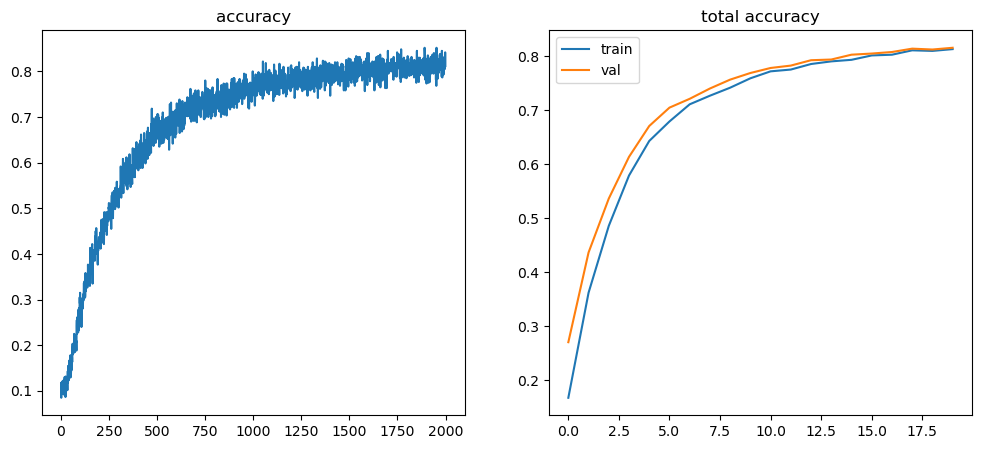

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(logger['accuracy'])
ax[0].set_title('accuracy')

ax[1].plot(logger['total_accuracy'], label='train')
ax[1].set_title('per epoch accuracy')
ax[1].plot(logger['total_val_accuracy'], label='val')
ax[1].legend()
plt.show()